## import all the required libraries

In [6]:
import string
import numpy as np
import os
from pickle import dump , load
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, get_file
from keras.layers import add
from keras.models import load_model , Model
from keras.layers import Input , Dense , LSTM , Embedding , Dropout

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()



C:\Users\hp\AppData\Local\Temp\ipykernel_31624\3118008753.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

### make functions for loading and image captioning

In [7]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def all_image_caption(filename):
    #each image have 5 caption
    file = load_doc(filename)
    captions = file.split('\n')
    discriptions = {}
    for caption in captions[:-1]:
        img,caption = caption.split('\t')
        if img[:-2] not in discriptions:
            discriptions[img[:-2]] = [caption]
        else:
            discriptions[img[:-2]].append(caption)
    return discriptions




    # xception model converts image into features
    # and while training , it cant generate outputs in a one go , 
    # it takes a feature , and previous word/charater to predict next word of the caption




### cleaning data 

In [8]:
# cleaning the data 
def cleaning(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i , img_caption in enumerate(caps):
            img_caption.replace('-',' ')
            desc = img_caption.split()
            #to lowecase
            desc = [word.lower() for word in desc]
            #remove punctuation
            desc = [word.translate(table) for word in desc ]

            desc = [word for word in desc if len(word)>1]
            # removing tokens with numbers in them
            desc = [word for word in desc if (word.isalpha())]

            img_caption = " ".join(desc)
            captions[img][i] = img_caption
    return captions




In [14]:
def text_vocab(discriptions):
    vocab = set()
    for key in discriptions.keys():
        [vocab.update(d.split()) for d in discriptions[key]]

    return vocab

def save_discriptions(discriptions, filename):
    lines =list()
    for key, desc_list in discriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
        data = '\n'.join(lines)
        file = open(filename,'w')
        file.write(data)
        file.close()


#data_text = 'flickr8k_text'
data_images = 'Flickr8k_Dataset'


filename =  'Flickr8k.token.txt'
discriptions = all_image_caption(filename)
print('length of discriptions = ' , len(discriptions))

clean_discriptions = cleaning(discriptions)
vocab = text_vocab(clean_discriptions)
print('length of vocabulary = ' , len(vocab))

save_discriptions(clean_discriptions , 'discriptions.txt')



    

length of discriptions =  8092
length of vocabulary =  8763


In [15]:
from PIL import Image

## we download the model

In [ ]:


def download_with_retry(url , filename , max_retry = 3):
    for attempt in range(max_retry):
        try:
            return get_file(filename , url)
        except Exception as e:
            if attempt == max_retry-1:
                raise 
            print(f'Download attempt failed')
            #time.sleep(3)

weights_url = "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_path = download_with_retry(weights_url, 'xception_weights.h5')

model = Xception(include_top=False  ,pooling='avg', weights=weights_path) 


 # transfer learning , not including last layer , add another pooling layer
def extract_features(directory):
    features = {}
    valid_images = ['.jpg' , '.jpeg' , '.png']

    for img in tqdm(os.listdir(directory)):
        ext = os.path.splitext(img)[1].lower()
        if ext not in valid_images:
            continue

        filename = directory + '/' + img
        image = Image.open(filename)
        image = image.resize((299,299)) # pixcel range 
        image = np.expand_dims(image, axis=0) # accepts in batches , 
        image = image/127.5
        image = image - 1.0

        feature = model.predict(image)    # THIS FEATURES WILL PASS ON TO A DIFFERENT MODEL
        features[img] = feature

    return features

features = extract_features(data_images)




C:\Users\hp\AppData\Local\Temp\ipykernel_31624\1579950689.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 159ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'features.p'

In [18]:
dump(features , open('features.p','wb'))

In [19]:
features = load(open("features.p","rb"))

In [24]:
# loading the data 
# input will be both image features and caption sequene , thats somethinf need to be remeber

def load_photos(filename):
    file = load_doc(filename)
    photos = file.split('\n')[:-1]
    photos_present = [photo for photo in photos if os.path.exists(os.path.join(data_images))]
    return photos_present


def load_lean_discriptions(filename , photos):
    file = load_doc(filename)
    discriptions = {}
    for line in file.split('\n'):
        words = line.split()
        if len(words) < 1:
            continue

        image , image_caption = words[0] , words[1:]
        if image in photos:
            if image not in discriptions:
                discriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + " <end>" # this is very important because thats where we apply start and end tag to the discriptions
            discriptions[image].append(desc)


    return discriptions







In [21]:
def load_fearures(photos):
    all_features = load(open('features.p','rb'))
    features = {k:all_features[k] for k in photos}
    #print(features)
    return features


In [80]:
filename =  "Flickr_8k.trainImages.txt"

train_imgs = load_photos(filename)
train_descriptions = load_lean_discriptions('discriptions.txt' , train_imgs)
train_features = load_fearures(train_imgs) 

def dict_to_list(discriptions):
    all_desc = []
    for key in discriptions.keys():
        [all_desc.append(d) for d in discriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

    








In [ ]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

In [41]:
def max_length(discriptions):
    desc_list = dict_to_list(discriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(train_descriptions)
print(max_length)



        ## 2 inputs (image feature and a sequence of caption) to the model , output will be one hot encoded

34


In [42]:

def create_sequences(Tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = Tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#checking the shape of the input and output for your model








In [45]:
def data_generator(discriptions , features, tokenizer, max_length):
    def generator():
        while True:
            for key, discription_list in discriptions.items():
                feature = features[key][0]
                input_image , input_sequence , output_word = create_sequences(tokenizer, max_length , discription_list, feature)
                for i in range(len(input_image)):
                    yield{'input_1': input_image[i], 'input_2': input_sequence[i]}, output_word[i]

    output_signature = (
        {
            'input_1': tf.TensorSpec(shape=(2048,), dtype=tf.float32),
            'input_2': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature= output_signature
    )

   
    return dataset.batch(32)

In [46]:
dataset = data_generator(train_descriptions, features, Tokenizer, max_length)
for (a, b) in dataset.take(1):
    print(a['input_1'].shape, a['input_2'].shape, b.shape)
    break

(32, 2048) (32, 34) (32, 7577)


In [47]:
def define_model(vocab_size, max_length):
    # CNN model from 2048 nodes to 256 nodes
    inputs1 = Input(shape=(2048,) , name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256 , activation='relu')(fe1)

    # LSTM model sequence
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size , 256 , mask_zero = True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    ## merging both models
    decoder1 = add([fe2,se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    model.compile(loss='categorical_crossentropy' , optimizer='adam')
    print(model.summary)

    return model


model = define_model(vocab_size, max_length)

epochs = 4

os.mkdir('models')
for i in range(epochs):
    dataset = data_generator(train_descriptions , train_features , Tokenizer, max_length)
    model.fit(dataset , epochs=epochs , steps_per_epoch=5, verbose=1)
    model.save('models/model_' + str(i) + '.h5')

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x000001E72C696F40>>
Epoch 1/4
5/5 [==============================] - 10s 362ms/step - loss: 8.8402
Epoch 2/4
5/5 [==============================] - 2s 305ms/step - loss: 8.2377
Epoch 3/4
5/5 [==============================] - 2s 317ms/step - loss: 7.1785
Epoch 4/4
5/5 [==============================] - 1s 293ms/step - loss: 7.2320


c:\Users\hp\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/4
5/5 [==============================] - 2s 328ms/step - loss: 4.8727
Epoch 2/4
5/5 [==============================] - 1s 277ms/step - loss: 4.7739
Epoch 3/4
5/5 [==============================] - 1s 265ms/step - loss: 5.0455
Epoch 4/4
5/5 [==============================] - 1s 264ms/step - loss: 5.2159
Epoch 1/4
5/5 [==============================] - 2s 273ms/step - loss: 4.5786
Epoch 2/4
5/5 [==============================] - 1s 274ms/step - loss: 4.5596
Epoch 3/4
5/5 [==============================] - 1s 263ms/step - loss: 4.6677
Epoch 4/4
5/5 [==============================] - 1s 274ms/step - loss: 4.9120
Epoch 1/4
5/5 [==============================] - 1s 274ms/step - loss: 4.2137
Epoch 2/4
5/5 [==============================] - 1s 265ms/step - loss: 4.2738
Epoch 3/4
5/5 [==============================] - 1s 295ms/step - loss: 4.3206
Epoch 4/4
5/5 [==============================] - 1s 270ms/step - loss: 4.4087


In [52]:
## testing model accuracy

import argparse
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=True , help = 'Image')
args = vars(ap.parse_args())
img_path = args['image']




usage: ipykernel_launcher.py [-h] -i IMAGE
ipykernel_launcher.py: error: the following arguments are required: -i/--image


SystemExit: 2

c:\Users\hp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [63]:
def word_for_id(integer , tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
        

    return None


def generate_desc(model , tokenizer , photo , max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = Tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=  max_length)
        pred = model.predict([photo, sequence] , verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, Tokenizer)
        if word is None:
            break
        in_text += ' '+ word
        if word == 'end':
            break

    return in_text

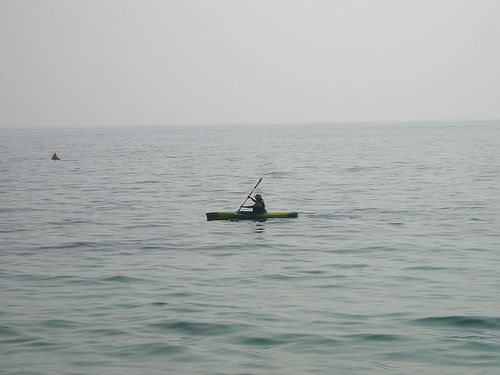

In [61]:
img_path = '19212715_20476497a3.jpg'
img = Image.open(img_path)
img

In [57]:
def extract_feature_test(filename , model):
    try:
        image = Image.open(filename)
    except:
        print('error')

    image = image.resize((299,299))
    image = np.array(image)
    if image.shape[2] == 4:
        image = image[..., 3]
    image = np.expand_dims(image , axis=0)
    image = image/127.5
    image = image-1.0
    feature = model.predict(image)
    return feature

In [ ]:
max_length = 32
tokenizer = load(open('Tokenizer.p', 'rb'))
vocab_size = len(tokenizer.word_index) + 1

model = define_model(vocab_size , max_length)
model.load_weights('models/model_3.h5')
xception_model = Xception(include_top = False , pooling='avg')

photo = extract_feature_test(img_path , xception_model)
#img = Image.open(img_path)


discription  = generate_desc(model , tokenizer , photo , max_length )
print(discription)
